In [1]:
!pip freeze

absl-py==0.9.0
albumentations==0.4.5
astunparse==1.6.3
attrs==19.3.0
backcall==0.2.0
bcolz==1.2.1
beautifulsoup4==4.6.3
bleach==3.1.5
blessings==1.7
bokeh==2.1.0
brotlipy==0.7.0
cachetools==4.1.0
certifi==2020.4.5.2
cffi==1.14.0
chardet==3.0.4
click==7.1.2
cliff==2.8.3
cloudpickle==1.4.1
cmd2==1.1.0
colorama==0.4.3
conda==4.8.3
conda-package-handling==1.7.0
configparser==5.0.0
cryptography==2.9.2
cssselect==1.0.3
cycler==0.10.0
cytoolz==0.10.1
dask==2.18.1
decorator==4.4.2
defusedxml==0.6.0
dicompyler-core==0.5.5
distributed==2.18.0
entrypoints==0.3
faiss==1.6.3
feather-format @ file:///home/conda/feedstock_root/build_artifacts/feather-format_1588949071708/work
fsspec==0.8.4
future==0.18.2
gast==0.3.3
google-auth==1.17.2
google-auth-oauthlib==0.4.1
google-pasta==0.2.0
gpustat==0.6.0
graphviz==0.14
grpcio==1.29.0
h5py==2.10.0
HeapDict==1.0.1
hiddenlayer==0.3
idna==2.9
imageio==2.8.0
imgaug==0.2.6
importlib-metadata==1.6.1
ipykernel==5.3.0
ipython @ file:///tmp/build/80754af9/ipython_159

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from torch.optim import Adam
import pytorch_lightning as pl

from data_loaders.chest_14_loader import Chest14Dataset
from data_loaders.rsna_loader import RSNADataset
import pandas as pd
from skimage import io, color
from skmultilearn.model_selection import iterative_train_test_split

from PIL import Image
import pydicom as dicom
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [23]:
transform=transforms.Compose([transforms.Grayscale(),
                              transforms.Resize((128,128)),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5,), (0.5,))
                             ])

In [6]:
d = RSNADataset(Path("/datasets/rsna"), part="full")
len(d)

29684

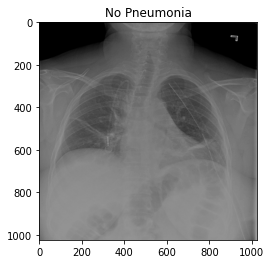

In [9]:
sample = d[1]
showInRow([sample['image']], [sample['label']])

# Parameters

In [49]:
# Chest 14
CHEST_14_DIR = Path("/datasets/chest-14/images")
CHEST_14_CSV = "/datasets/chest-14/Data_Entry_2017.csv"
TRAIN_SPLIT_FILE = "/datasets/chest-14/train_val_list.txt"
TEST_SPLIT_FILE = "/datasets/chest-14/test_list.txt"

# Chest Pneumonia
PNEUMONIA_TRAIN_DIR = Path("/datasets/chest-xray-pneumonia/train/PNEUMONIA")
NORM_TRAIN_DIR = Path("/datasets/chest-xray-pneumonia/train/NORMAL")

PNEUMONIA_VAL_DIR = Path("/datasets/chest-xray-pneumonia/val/PNEUMONIA")
NORM_VAL_DIR = Path("/datasets/chest-xray-pneumonia/val/NORMAL")

PNEUMONIA_TEST_DIR = Path("/datasets/chest-xray-pneumonia/test/PNEUMONIA")
NORM_TEST_DIR = Path("/datasets/chest-xray-pneumonia/test/NORMAL")

# RSNA
RSNA_TRAIN_DIR = Path("/datasets/rsna/stage_2_train_images")
RSNA_TEST_DIR = Path("/datasets/rsna/stage_2_test_images/")
RSNA_TRAIN_LABELS = "/datasets/rsna/stage_2_train_labels.csv"
RSNA_TEST_LABELS = "/datasets/rsna/stage_2_sample_submission.csv"


BATCH_SIZE = 128
WORKERS = 2
VAL_SPLIT = 0.2

In [19]:
pd.read_csv("/datasets/rsna/stage_2_sample_submission.csv").columns

Index(['patientId', 'PredictionString'], dtype='object')

In [17]:
len(list(Path("/datasets/rsna/stage_2_test_images/").glob("*")))

3000

# Help functions

In [4]:
def showInRow(list_of_images, titles = None, 
              disable_ticks = False, vertical=False,
              tensor=False):
    tensor_to_img = transforms.ToPILImage()
    to_gray = transforms.Grayscale()
    count = len(list_of_images)
    for idx in range(count):
        if vertical:
            subplot = plt.subplot(count, 1, idx+1)
        else:
            subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])
        img = list_of_images[idx]
        if tensor:
            img = tensor_to_img(img)
            img = to_gray(img)
        
        img = np.array(img)
        
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

# Dataset for Chest-14

In [10]:
class Chest14Dataset(Dataset):
    """Chest 14 dataset."""

    def __init__(self, csv_file:str, root_dir:Path, split_file:str, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
        self.label_to_idx = {
            "No Finding": 0,
            "Atelectasis": 1,
            "Cardiomegaly": 2,
            "Effusion": 3,
            "Infiltration": 4,
            "Mass": 5,
            "Nodule": 6,
            "Pneumonia": 7,
            "Pneumothorax": 8,
            "Consolidation": 9,
            "Edema": 10,
            "Emphysema": 11,
            "Fibrosis": 12,
            "Pleural_Thickening": 13,
            "Hernia": 14
        }
        
        self.idx_to_label = {}
        for label, idx in self.label_to_idx.items():
            self.idx_to_label[idx] = label
            
        self._make_split(split_file)
    
    def get_labels(self):
        labels = self.csv_data['Finding Labels'].tolist()
        for i in range(len(labels)):
            labels[i] = self.label_to_one_hot(labels[i])
        return np.array(labels)
    
    def _make_split(self, split_file):
        image_names  = []
        with open(split_file, "r") as f:
            image_names = f.read().split("\n")
        self.csv_data = self.csv_data[self.csv_data['Image Index'].isin(image_names)]
        
    
    def label_to_one_hot(self, label_string):
        labels = label_string.split("|")
        one_hot_label = np.zeros(len(self.label_to_idx.keys()))
        for label in labels:
            idx = self.label_to_idx[label]
            one_hot_label[idx] = 1
        return one_hot_label
        
    def one_hot_to_label(self, one_hot_label):
        if len(one_hot_label) != len(self.label_to_idx.keys()):
            return "Undefined"
        else:
            labels = []
            for i in len(one_hot_label):
                if(one_hot_label[i]):
                    labels.append(self.idx_to_label[i])
            return "|".join(labels)

    def __len__(self):
        return len(self.csv_data)
    


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir / self.csv_data.iloc[idx, 0]
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
            
    
        
        label = self.csv_data.iloc[idx, 1]
        one_hot_label = self.label_to_one_hot(label)
        

        sample = {'image': image, 
                  'one_hot_label':  torch.tensor(one_hot_label).float(), 
                  'label':label}
        return sample

In [35]:
class RSNADataset(Dataset):
    """RSNA dataset."""

    def __init__(self, csv_file:str, root_dir:Path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_data = pd.read_csv(csv_file).drop_duplicates(subset=['patientId'])
        self.root_dir = root_dir
        self.transform = transform
        
    
    def get_labels(self):
        labels = self.csv_data['Target_'].tolist()
        for i in range(len(labels)):
            labels[i] = self.label_to_one_hot(labels[i])
        return np.array(labels)
    
    
    def label_to_one_hot(self, label):
        one_hot_label = np.zeros(2)
        one_hot_label[label] = 1
        return one_hot_label
        
    def one_hot_to_label(self, one_hot_label):
        if len(one_hot_label) != 2:
            return "Undefined"
        else:
            return np.argmax(one_hot_label)

    def __len__(self):
        return len(self.csv_data)
    


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.root_dir / (self.csv_data.iloc[idx, 0]+'.dcm')
        image = dicom.dcmread(img_name)
        image = Image.fromarray(image.pixel_array.astype(np.uint8))
        if self.transform:
            image = self.transform(image)
            
    
        
        label = self.csv_data.iloc[idx, 5]
        one_hot_label = self.label_to_one_hot(label)
        

        sample = {'image': image, 
                  'one_hot_label':  torch.tensor(one_hot_label).float(), 
                  'label':label}
        return sample

In [51]:
class PneumoniaDataset(Dataset):
    """RSNA dataset."""

    def __init__(self, pneumo_dir:Path, norm_dir:Path, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.pneumo_imgs = list(pneumo_dir.glob("*.jpeg"))
        self.norm_imgs = list(norm_dir.glob("*.jpeg"))
        self.transform = transform
    
    def label_to_one_hot(self, label):
        one_hot_label = np.zeros(2)
        one_hot_label[label] = 1
        return one_hot_label
        
    def one_hot_to_label(self, one_hot_label):
        if len(one_hot_label) != 2:
            return "Undefined"
        else:
            return np.argmax(one_hot_label)

    def __len__(self):
        return len(self.pneumo_imgs)+len(self.norm_imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if idx < len(self.pneumo_imgs):
            img_name = self.pneumo_imgs[idx]
            label = 1
        else:
            img_name = self.norm_imgs[idx-len(self.pneumo_imgs)]
            label = 0
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
            
        one_hot_label = self.label_to_one_hot(label)
        

        sample = {'image': image, 
                  'one_hot_label':  torch.tensor(one_hot_label).float(), 
                  'label':label}
        return sample

In [12]:
transform=transforms.Compose([transforms.Grayscale(),
                              transforms.Resize((128,128)),
                              transforms.ToTensor(),
                              #transforms.Normalize((0.5,), (0.5,))
                             ])

dataset_train = Chest14Dataset(csv_file=CHEST_14_CSV, 
                               root_dir=CHEST_14_DIR,
                               split_file=TRAIN_SPLIT_FILE,
                               transform=transform)

dataset_test = Chest14Dataset(csv_file=CHEST_14_CSV, 
                              root_dir=CHEST_14_DIR,
                              split_file=TEST_SPLIT_FILE,
                              transform=transform)

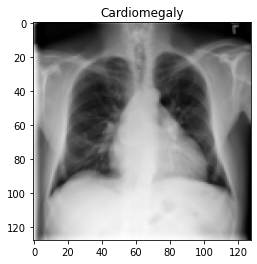

In [15]:
sample = dataset_train[0]
showInRow([sample["image"]],[sample["label"]], tensor=True)

In [36]:
d = RSNADataset(csv_file=RSNA_TRAIN_LABELS, 
                root_dir=RSNA_TRAIN_DIR,
                transform=transform)

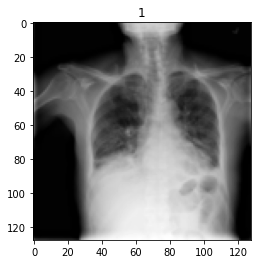

In [44]:
sample = d[7]
showInRow([sample["image"]],[sample["label"]], tensor=True)

In [45]:
d = RSNADataset(csv_file=RSNA_TEST_LABELS, 
                root_dir=RSNA_TEST_DIR,
                transform=transform)

In [46]:
sample = d[7]
showInRow([sample["image"]],[sample["label"]], tensor=True)

IndexError: single positional indexer is out-of-bounds

In [52]:
d = PneumoniaDataset(pneumo_dir=PNEUMONIA_TRAIN_DIR, 
                     norm_dir=NORM_TRAIN_DIR,
                     transform=transform)

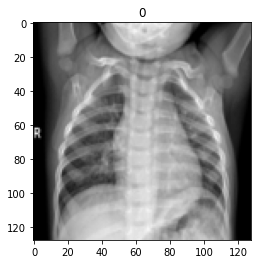

In [58]:
sample = d[5000]
showInRow([sample["image"]],[sample["label"]], tensor=True)

# Split data on train val test splits

In [7]:
train_len = int(len(dataset_train) * (1-VAL_SPLIT))
val_len = len(dataset_train) - train_len

print("Before splitting:")
print("\tTrain dataset:", len(dataset_train))
print("\tTest dataset:", len(dataset_test))

dataset_train, dataset_val = random_split(dataset_train, (train_len, val_len))


print("After splitting:")
print("\tTrain dataset:", len(dataset_train))
print("\tVal dataset:", len(dataset_val))
print("\tTest dataset:", len(dataset_test))

Before splitting:
	Train dataset: 86524
	Test dataset: 25596
After splitting:
	Train dataset: 69219
	Val dataset: 17305
	Test dataset: 25596


# Define data loaders

In [8]:
class MyModel(pl.LightningModule):
    
    def __init__(self, class_num):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, class_num)
        
        self.accuracy = pl.metrics.Accuracy()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.sigmoid(x)
    
    def training_step(self, batch, batch_idx):
        images, labels = \
            batch['image'], batch['one_hot_label']
        images = images.cuda()
        labels = labels.cuda()
        logits = self(images)
        loss = self.categorical_cross_entropy(logits, labels)
        return loss
    
    def test_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['one_hot_label']
        logits = self(images)
        loss = F.nll_loss(logits, labels)
        print('test_loss', loss)
    
    def categorical_cross_entropy(self, predictions, labels):
        epsilon=1e-12
        predictions = torch.clamp(predictions, epsilon, 1. - epsilon)
        N = len(predictions)
        loss = -torch.sum(labels * torch.log(predictions+1e-9))/N
        return loss
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    
    def train_dataloader(self):
        return DataLoader(dataset_train, batch_size=BATCH_SIZE, 
                          num_workers=WORKERS)

    def val_dataloader(self):
        return DataLoader(dataset_val, batch_size=BATCH_SIZE,
                          num_workers=WORKERS)

    def test_dataloader(self):
        return DataLoader(dataset_test, batch_size=BATCH_SIZE, 
                          num_workers=WORKERS)

In [9]:
model = MyModel(15)
if torch.cuda.is_available():
    model = model.cuda()

In [11]:
trainer = pl.Trainer(gpus=1)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name     | Type      | Params
---------------------------------------
0 | conv1    | Conv2d    | 156   
1 | pool     | MaxPool2d | 0     
2 | conv2    | Conv2d    | 2 K   
3 | fc1      | Linear    | 1 M   
4 | fc2      | Linear    | 10 K  
5 | fc3      | Linear    | 1 K   
6 | accuracy | Accuracy  | 0     
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: Us

/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Saving latest checkpoint..


/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


1

In [18]:
sample1 = dataset_train[7]
img, lab = sample['image'], sample['one_hot_label']
img = torch.unsqueeze(img, 0).cuda()
lab = lab.cuda()
model.cuda()
model(img)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [42]:
trainer.test(model)

/home/intern/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [33]:
sample1 = dataset_train[1]
sample2 = dataset_train[6]

lab1 = sample1['one_hot_label']
lab2 = sample2['one_hot_label']
print(lab1)
print(lab2)

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [213]:
model.categorical_cross_entropy(lab1, lab2)

tensor(-0.)

In [226]:
len(lab1)

15

In [222]:
torch.cuda.get_device_name()

'GeForce GTX 1080 Ti'

In [234]:
torch.cuda.current_device() 

0

In [34]:
accuracy = pl.metrics.Accuracy()
accuracy(lab1, lab1)

tensor(1.)